# Tutorial 1: Standard REXEE simulations

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/wehs7661/ensemble_md/c0f6d48ce3fe746e349e4a4a9610f935cca8b0b5?urlpath=lab%2Ftree%2Fdocs%2Fexamples%2Ftutorial_1%2Frun_REXEE.ipynb)

In this tutorial, we will demonstrate how one can use the different command-line interfaces (CLIs) implemented in the Python package `ensemble_md` to prepare, perform, and analyze a REXEE simulation to estimate the solvation free energy of a toy molecule composed of 4 interaction sites. For a more comprehensive understanding, we strongly recommend reading our [documentation](https://ensemble-md.readthedocs.io/en/latest/simulations.html) on launching REXEE simulations before starting this tutorial. With MPI (`mpirun` or `mpiexec`), GROMACS and `ensemble_md` all installed, you should be able to run this tutorial either locally or on a HPC cluster, as long as you have at least four CPU cores. Alternatively, you can click the badge above to run this tutorial on Binder without installing anything. Notably, this tutorial assumes that you understand the basics of the expanded ensemble (EE) method and relevant simulation parameters in GROMACS. If not, we recommend reading the [GROMACS documentation](https://manual.gromacs.org/current/reference-manual/algorithms/expanded-ensemble.html) and/or [this tutorial](https://weitsehsu.com/course/advanced_sampling/exe/). 

## 0. Background knowledge: A two-stage protocol

In methods such as expanded ensembles or REXEE, where each alchemical state has an associated weight (see [here](https://ensemble-md.readthedocs.io/en/latest/simulations.html)), it is common to use a two-stage protocol for alchemical free energy calculations. Specifically, this protocol is composed of the following two stages:

- A **weight-updating stage**: In a weight-updating stage, the weights of the different states are constantly updated until convergence during the simulation, usually by methods such as the Wang-Landau algorithm or its $1/t$ variant. The purpose of this stage is to obtain weights that could flatten out the free energy surface along the alchemical direction such that all states have a roughly equal chance to be visited in the next stage, i.e., the fixed-weight stage. 
- A **fixed-weight stage**: In a fixed-weight stage, the weights of different alchemical states are fixed at predefined values usually converged in a weight-updating stage. Unlike weight-updating simulations, a fixed-weight simulation is in equilibrium, and can therefore be analyzed by free energy estimators that require equilibrium data for free energy calculations, such as TI, BAR, MBAR, etc. 

With this protocol, one can use a weight-updating EE/REXEE simulation followed by a fixed-weight EE/REXEE simulation. In our [paper](https://pubs.acs.org/doi/10.1021/acs.jctc.4c00484), we have compared EE and REXEE methods in both weight-updating and fixed-weight phases comprehensively. 

Notably, this tutorial will only focus on fixed-weight REXEE simulations, with the weights provided by a weight-updating EE simulation not shown here. A weight-updating REXEE simulation can be performed simply by using the same workflow for running fixed-weight REXEE simulations, with input MDP files replaced by the ones for weight-updating EE simulations.

## 1. Preparing simulation inputs for a REXEE simulation

As mentioned in our documentation, running a REXEE simulation at least requires the following four input files:

- One YAML file that specifies REXEE parameters.
- One GROMACS GRO file of the system of interst.
- One GROMACS TOP file of the system of interst.
- One GROMACS MDP template for customizing MDP files for different replicas during the simulation.

In the folder where this tutorial resides (`docs/examples/tutoria_1` in the repository), you should find all these necessary input files, including `params.yaml`, `sys.gro`, `sys.top`, and `expanded.mdp`. (Note that the file `example_outputs.zip` is not relevant until the last section of this notebook.)

In [1]:
!ls

example_outputs.zip  params.yaml	   sys.gro
expanded.mdp	     standard_REXEE.ipynb  sys.top


While you could use multiple GRO and TOP files, one for each replica in a REXEE simulation, in this tutorial, we will use the same GRO and TOP files for all replicas to keep the demonstration straightforward. As for the MDP template `expanded.mdp`, it can be inspected that it adopts common/typical settings for a fixed-weight EE simulation, since here our goal is to set up a fixed-weight REXEE simulation. In the MDP template, it can also be seen that 9 alchemical intermediate states are defined to decouple van der Waals interactions and coulombic interactions. 

During the REXEE simulation, customized MDP files will be generated for different replicas such that the MDP file for each replica only consider the set of states that the replica is constrained to. Notably, the weights specified via the parameter `init_lambda_weights` were obtained from a weight-updating EE simulation. If you would like to run a weight-updating REXEE simulation, simply use an MDP file for running a weight-updating EE simulation, i.e., and MDP file without `init_lambda_weights` being specified, and with options such as `wl_scale`, `wl_ratio`, `init_wl_delta`, `lmc_stats`, `lmc_weights_equil`, `weight_equil_wl_delta` specified.

Now, with these three GROMACS inputs prepared, let's briefly review the input YAML file that specifies REXEE parameters.

In [2]:
!cat params.yaml

# Simulation parameters
gmx_executable: 'gmx'               
gro: sys.gro
top: sys.top
mdp: expanded.mdp             
n_sim: 4
n_iter: 5         
s: 1                         
nst_sim: 500
runtime_args: {'-nt': '1'}

# Data analysis parameters
free_energy: True


As a minimum working example, this YAML file only specifies the compulsory simulation parameters and adopts default values for all optional parameters, execpt that `runtime_args` is specified to run each EE replica using one thread (`-nt 1`) so that it would not take too long to complete the simulation. For information about all possible parameters that can be specified in the YAML file, please refer to our [documentation](https://ensemble-md.readthedocs.io/en/latest/simulations.html#input-yaml-parameters).

In our case, we will run our a REXEE simulation composed of 4 replicas, with each replica performed with one thread (`-nt 1`). With the total number of states as 9 and a state shift of 1, this means that replicas 0, 1, 2, 3 are constrained to sampling states 0-5, 1-6, 2-7, and 3-8, respectively. The simulation will attempt to swap coordinates between replicas every 500 integration steps, and perform 5 iterations in total. (Note that generally we need a much larger number of iterations. Here we use a very small value just for demosntration purposes.) 

If you are interested in trying out other numbers of replicas or state shifts given 9 alchemical intermediate states, you can use the CLI `explore_REXEE` to enumerate all possible REXEE configurations.

In [3]:
!explore_REXEE -N 9

Exploration of the REXEE parameter space
[ REXEE parameters of interest ]
- N: The total number of states
- r: The number of replicas
- n: The number of states for each replica
- s: The state shift between adjacent replicas

[ Solutions ]
- Solution 1: (N, r, n, s) = (9, 2, 5, 4)
  - Replica 0: [0, 1, 2, 3, 4]
  - Replica 1: [4, 5, 6, 7, 8]

- Solution 2: (N, r, n, s) = (9, 2, 6, 3)
  - Replica 0: [0, 1, 2, 3, 4, 5]
  - Replica 1: [3, 4, 5, 6, 7, 8]

- Solution 3: (N, r, n, s) = (9, 2, 7, 2)
  - Replica 0: [0, 1, 2, 3, 4, 5, 6]
  - Replica 1: [2, 3, 4, 5, 6, 7, 8]

- Solution 4: (N, r, n, s) = (9, 2, 8, 1)
  - Replica 0: [0, 1, 2, 3, 4, 5, 6, 7]
  - Replica 1: [1, 2, 3, 4, 5, 6, 7, 8]

- Solution 5: (N, r, n, s) = (9, 3, 5, 2)
  - Replica 0: [0, 1, 2, 3, 4]
  - Replica 1: [2, 3, 4, 5, 6]
  - Replica 2: [4, 5, 6, 7, 8]

- Solution 6: (N, r, n, s) = (9, 3, 7, 1)
  - Replica 0: [0, 1, 2, 3, 4, 5, 6]
  - Replica 1: [1, 2, 3, 4, 5, 6, 7]
  - Replica 2: [2, 3, 4, 5, 6, 7, 8]

- Solution 7: (

If you want to list all possible configurations that use 4 replicas for sampling 9 alchemical states, you can further specify the number of replicas via the flag `-r`:

In [4]:
!explore_REXEE -N 9 -r 4

Exploration of the REXEE parameter space
[ REXEE parameters of interest ]
- N: The total number of states
- r: The number of replicas
- n: The number of states for each replica
- s: The state shift between adjacent replicas

[ Solutions ]
- Solution 1: (N, r, n, s) = (9, 4, 3, 2)
  - Replica 0: [0, 1, 2]
  - Replica 1: [2, 3, 4]
  - Replica 2: [4, 5, 6]
  - Replica 3: [6, 7, 8]

- Solution 2: (N, r, n, s) = (9, 4, 6, 1)
  - Replica 0: [0, 1, 2, 3, 4, 5]
  - Replica 1: [1, 2, 3, 4, 5, 6]
  - Replica 2: [2, 3, 4, 5, 6, 7]
  - Replica 3: [3, 4, 5, 6, 7, 8]



For rules of thumb about specifying the configurational parameters (including the number of states, number of replicas, state shift and swapping frequency), please refer to our [documentation](https://ensemble-md.readthedocs.io/en/latest/simulations.html#some-rules-of-thumb) or [paper](https://pubs.acs.org/doi/epdf/10.1021/acs.jctc.4c00484).

## 2. Performing a REXEE simulation
With all the input files in place, we can now run a fixed-weight REXEE simulation using the CLI `run_REXEE` with the command shown below. 

If you are using a laptop with 4 CPU cores, this should take around 15 minutes to complete. If you run the tutorial on Binder, this should take around 3 minutes. Note that here we use default values for all flags of the CLI `run_REXEE`. For more information about the flags, please run `run_REXEE -h`/`run_REXEE --help` and read the help message.

In [5]:
!mpirun -np 4 run_REXEE

Current time: 31/07/2024 15:47:40
Command line: /srv/conda/envs/notebook/bin/run_REXEE

Important parameters of REXEE
Python version: 3.10.14 | packaged by conda-forge | (main, Mar 20 2024, 12:45:18) [GCC 12.3.0]
GROMACS executable: /srv/conda/envs/notebook/bin.AVX2_256/gmx
GROMACS version: 2023.3-conda_forge
ensemble_md version: 0.9.0+173.g24861ff.dirty
Simulation inputs: sys.gro, sys.top, expanded.mdp
Verbose log file: True
Proposal scheme: exhaustive
Whether to perform weight combination: False
Type of means for weight combination: simple
Whether to perform histogram correction: False
Histogram cutoff for weight correction: -1
Number of replicas: 4
Number of iterations: 5
Length of each replica: 1.0 ps
Frequency for checkpointing: 100 iterations
Total number of states: 9
Additionally defined swappable states: None
Additional grompp arguments: None
Additional runtime arguments: {'-nt': '1'}
External modules for coordinate manipulation: None
MDP parameters differing across replicas: N

As shown above, the CLI `run_REXEE` printed information about the simulation on-the-fly, including the number of iterations completed, information about the current iteration, whether a swap was accepted or not, etc. At the end, a summary of the simulation was printed. All such information is saved in `run_REXEE_log.txt`. Below we list the files in the current directory and print the directory structure to see what outputs have been generated by the simulation:

In [6]:
!ls

example_outputs.zip  rep_trajs.npy	sim_1  standard_REXEE.ipynb
expanded.mdp	     run_REXEE_log.txt	sim_2  sys.gro
params.yaml	     sim_0		sim_3  sys.top


In [7]:
!tree sim_0

sim_0
├── iteration_0
│   ├── confout.gro
│   ├── dhdl.xvg
│   ├── ener.edr
│   ├── expanded.mdp
│   ├── md.log
│   ├── mdout.mdp
│   ├── sys_EE.tpr
│   └── traj_comp.xtc
├── iteration_1
│   ├── confout.gro
│   ├── dhdl.xvg
│   ├── ener.edr
│   ├── expanded.mdp
│   ├── md.log
│   ├── mdout.mdp
│   ├── sys_EE.tpr
│   └── traj_comp.xtc
├── iteration_2
│   ├── confout.gro
│   ├── dhdl.xvg
│   ├── ener.edr
│   ├── expanded.mdp
│   ├── md.log
│   ├── mdout.mdp
│   ├── sys_EE.tpr
│   └── traj_comp.xtc
├── iteration_3
│   ├── confout.gro
│   ├── dhdl.xvg
│   ├── ener.edr
│   ├── expanded.mdp
│   ├── md.log
│   ├── mdout.mdp
│   ├── sys_EE.tpr
│   └── traj_comp.xtc
└── iteration_4
    ├── confout.gro
    ├── dhdl.xvg
    ├── ener.edr
    ├── expanded.mdp
    ├── md.log
    ├── mdout.mdp
    ├── sys_EE.tpr
    └── traj_comp.xtc

6 directories, 40 files


As shown above, the following files/directories have been generated:
- Folders `sim_*`, each of which corresponds to a replica in the REXEE simulation and contains subfolders `iteration_*`, where simulation outputs of each iteration reside.
- `rep_trajs.npy`, which contains replica-space trajectories for all replicas and is used as an input checkpoint file when simulation extension is desired. To extend a REXEE simulation, one only needs to input `rep_trajs.npy` via the `-c` flag of `run_REXEE`.
- `run_REXEE_log.txt`, a log file as mentioned above.

Notably, if a weight-updating REXEE simulation is performed, `g_vecs.npy` will be generated, which contains the times series of alchemical weights for all replicas.

## 3. Analyzing a REXEE simulation

After the simulation is completed, we are ready to analyze the simulation to assess its sampling behaviors and estimate the solvation free energy of the molecule. Since the simulation we performed in the previous section is very short and was just for demonstration purposes, instead of using the simulation outputs above, we will unzip `example_outputs.zip` and analyze the outputs from an example simulation using the CLI `analyze_REXEE`. 

In [8]:
!unzip example_outputs.zip > /dev/null 2>&1  # Here we discard the STDOUT as it's verbose and irrelvant

In the folder `example_outputs`, you can find `expanded.mdp` and `params.yaml` used to perform the example simulation, as well as the outputs generated by the simulation mentioned above, including `rep_trajs.npy`, `run_REXEE_log.txt`, and folders `sim_*`. To save space, we have only preserved DHDL and LOG files for each iteration of each replica in the folders `sim_*`, as they are the only files needed for data analysis using the CLI `analyze_REXEE`. All other GROMACS outputs have been removed. 

In [9]:
!cd example_outputs && ls

expanded.mdp  rep_trajs.npy	 sim_0	sim_2
params.yaml   run_REXEE_log.txt  sim_1	sim_3


Notably, the example simulation adopted the same MDP template and REXEE configuration we used in the previous section. The only differences between the example simulation and the one we performed in the previous section lie in the following settings in the input YAML file:
- `n_iter` and `nst_sim`: The example simulation performed 125 iterations (instead of 5 iterations), each of which runs for 5000 (instead of 500) integration steps. Given that we have four replicas, this sum up to an aggregation length of 5000 steps/iteration * 0.002 ps/step * 125 iteration/replica * 4 replicas = 5000 ps, or 5 ns. Though this is still a very short simulation for getting a reliable free energy estimate, it is sufficient to demonstrate the utility of the CLI `analyze_REXEE`.
- `runtime_args`: The example simulation adopted a different set of runtime arguments, including `-nt 16` and `-ntmpi 1`. This is just to ensure a reasonable performance for the simulation, which was performed on a 64-core node on Bridges-2. 

In [10]:
!diff expanded.mdp example_outputs/expanded.mdp

In [11]:
!diff params.yaml example_outputs/params.yaml

7c7
< n_iter: 5         
---
> n_iter: 125     
9,10c9,10
< nst_sim: 500
< runtime_args: {'-nt': '1'}
---
> nst_sim: 5000
> runtime_args: {'-nt': '16', '-ntmpi': '1'}


Importantly, the CLI `analyze_REXEE` also requires an input YAML file, which can be the same as the one used for `run_REXEE` (as in our case), since these two CLIs only consider their own relevant parameters. Regardless of the data analysis parameters specified in the input YAML file, the CLI `analyze_REXEE` will perform the following analyses. (For more information, please check the [API documentation](https://ensemble-md.readthedocs.io/en/latest/api/api_analysis.html) of the relevant functionalities, or the [source code](https://github.com/wehs7661/ensemble_md/blob/master/ensemble_md/cli/analyze_REXEE.py) of the CLI `analyze_REXEE`.)

- Read in and plot replica-space trajectories (using `ensemble_md.analyze_traj.plot_rep_trajs`)
- Calculate and plot the replica-space transition matrix (using `ensemble_md.analyze_traj.tarj2transmtx` and `ensemble_md.analyze_matrix.plot_matrix`)
- Calculate the spectral gap for the replica-space transition matrix (using `ensemble_md.analyze_matrix.calc_spectral_gap`) 
- Recover all configurationally continuous trajectories in the state space (using `ensemble_md.analyze_traj.stitch_time_series`)
- Plot the state-space time series for different continuous trajectories (using `ensemble_md.analyze_traj.plot_state_trajs`)
- Plot the histograms of state index for different continuous trajectories (using `ensemble_md.analyze_traj.plot_state_hist`)
- Stitch the time series of state index for different sets of states (using `ensemble_md.analyze_traj.stitch_time_series_for_sim`)
- Plot the time series of state index for different sets of states (using `ensemble_md.analyze_traj.plot_state_trajs`)
- Plot the histograms of state index for different sets of states (using `ensemble_md.analyze_traj.plot_state_hist`)
- Plot the overall state-space transition matrices for different continuous trajectories (using `ensemble_md.analyze_traj.traj2transmtx` and `ensemble_md.analyze_matrix.plot_matrix`)
- For each continuous trajectory, calculate the state-space spectral gap (using `ensemble_md.analyze_matrix.calc_spectral_gap`)
- For each continuous trajectory, calculate the state-space stationary distribution (using `ensemble_md.analyze_matrix.calc_equil_prob`)
- Calculate the state index correlation time for each continuous trajectory (using `pymbar.timeries.statistical_inefficiency`)
- Calculate transit times for each continuous trajectory (using `ensemble_md.analyze_traj.plot_transit_time`)

Additionally, MSM analysis and free energy calculations can be performed if parameters `msm` and `free_energy` are set to `True`, respectively. Here, we set `free_energy` to `True` in `params.yaml` (with all other data analysis parameters adopting their default values), so free energy calculations will be performed when the CLI `analyze_REXEE` is used. 

Now, to perform data analysis on the example outputs, simply execute the command in the cell below. Note that the CLI `analyze_REXEE` should be run in the same directory where the MDP template, input YAML file, and `sim_*` folders reside. Also, the CLI `analyze_REXEE` does not support parallelism and here we are using default values for all the flags. For more information about the flags, please run `analyze_REXEE -h`/`analyze_REXEE --help` and read the help message. On Binder, the data analysis will take around 30 minutes to complete.

In [12]:
!cd example_outputs && mpirun -np 1 analyze_REXEE

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

********* JAX NOT FOUND *********
 PyMBAR can run faster with JAX  
 But will work fine without it   
Either install with pip or conda:
      pip install pybar[jax]     
               OR                
      conda install pymbar       
*********************************
Current time: 31/07/2024 15:50:46
Command line: /srv/conda/envs/notebook/bin/analyze_REXEE
Important parameters of REXEE
Python version: 3.10.14 | packaged by conda-forge | (main, Mar 20 2024, 12:45:18) [GCC 12.3.0]
GROMACS executable: /srv/conda/envs/notebook/bin.AVX2_256/gmx
GROMACS version: 2023.3-conda_forge
ensemble_md version: 0.9.0+173.g2486

In [13]:
!ls example_outputs

analysis	       rep_trajs.npy	  sim_3
analyze_REXEE_log.txt  run_REXEE_log.txt  state_trajs_for_sim.npy
expanded.mdp	       sim_0		  state_trajs.npy
hist_data.npy	       sim_1
params.yaml	       sim_2


In [14]:
!ls example_outputs/analysis

free_energy_profile.png      t_k0.png
rep_trajs.png		     traj_0_state_transmtx.png
rep_transmtx_allconfigs.png  traj_1_state_transmtx.png
state_hist_for_sim.png	     traj_2_state_transmtx.png
state_hist.png		     traj_3_state_transmtx.png
state_trajs_for_sim.png      t_roundtrip.png
state_trajs.png		     u_nk_data.pickle
t_0k.png


As shown above, all data analysis results were not only printed on the fly to the screen, but also printed to the file `analyze_REXEE_log.txt`. Additionally, the following files and folders have been generated by `analyze_REXEE`:
- `state_trajs.npy`: An NPY file that contains the stitched state-space trajectories of different replicas
- `state_trajs_for_sim.npy`: An NPY file that contains the stitched state-space time series for different state sets
- `hist_data.npy`: An NPY file that stores the state-space visitation distribution
- A folder `analysis`, which contains a bunch of figures generated from different analyses (listed above), and the file `u_nk_data.pickle`, which contains preprocessed `u_nk` data. This file is useful for significantly shortening the analysis time when one wants to rerun free energy calculations for the same simulation, as the CLI `analyze_REXEE` will search for files such as `u_nk_data.pickle` (for BAR or MBAR calculations) or `dhdl_data.pickle` (for TI calculations) and if a pickle file is found, the data preprocessing step will be skipped. 

## 4. Analysis results
Here we show some of the figures generated by the analysis but will not cover too many details in their interpretations, as the example simulation is short and only for demonstration purposes. For more insights into data interpretation, please refer to our [JCTC paper](https://pubs.acs.org/doi/epdf/10.1021/acs.jctc.4c00484).

Now, here are just some settings for displaying figures.

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as image
from IPython.display import display, Image

def display_images_matplotlib(images, widths=None, figsize=(10, 5), rows=1, titles=None):
    """
    Display a list of images in a grid using Matplotlib with specified widths.

    Parameters
    ----------
    images : List[str]
        List of image paths.
    widths : List[float]
        A list containing the width of each image as a percentage of the total width. Must add up to 100.
    figsize : tuple
        Size of the entire figure (width, height).
    rows : int
        Number of rows in the grid.
    titles : List[str]
        List of titles for each image. If None, no titles will be displayed.
    """
    cols = len(images) // rows + int(len(images) % rows != 0)
    
    if widths is None:
        widths = [100 / len(images) for _ in images]
    else:
        assert sum(widths) == 100, "The widths must add up to 100."

    fig, axes = plt.subplots(rows, cols, figsize=figsize, gridspec_kw={'width_ratios': widths})
    axes = axes.flatten()
    
    for i, (img_path, ax) in enumerate(zip(images, axes)):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis('off')
        if titles is not None:
            ax.set_title(titles[i])
    
    # Hide any remaining empty subplots
    for ax in axes[len(images):]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

## 4.1. Replica-space sampling
As shown in the replica-space trajectories in the left figure below, each replica was able to sample all different sets of states by exchanging coordinates with other replicas, indicating good sampling in the replica space. This decent sampling in the replica space is also reflected in the replica-space transition matrix, as shown in the right figure.

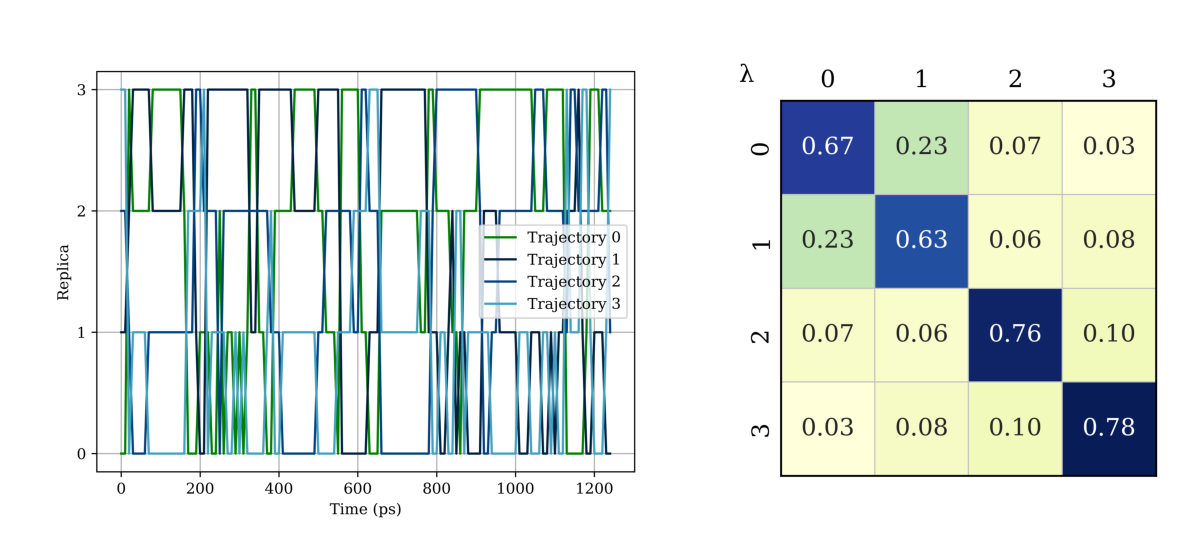

In [19]:
images = ['example_outputs/analysis/rep_trajs.png', 'example_outputs/analysis/rep_transmtx_allconfigs.png']
display_images_matplotlib(images, rows=1, widths=[60, 40], figsize=(12, 6))

### 4.2. State-space sampling
The left figure of state-space trajectories below shows that each replica was able to sample all alchemical intermediate states, which requires not only replica-space transitions but also state-space transitions facilitated by alchemical weights that flatten out the free energy surface along the alchemical direction. In the right figure, we show the visitation distribution in the state space, with contributions of visitation counts from different replicas shown in different colors. As some of the states can be accessed by multiple replicas, it is natural to not have a flat accumulate histgram here. In fact, the count of each state should be proportional to the number of replicas that can access the state in an ideal case, i.e., each replica has an even sampling across all states. 

In [ ]:
images = ['example_outputs/analysis/state_trajs.png', 'example_outputs/analysis/state_hist.png']
display_images_matplotlib(images, rows=1)

Similarly, the efficient sampling in the state space is reflected by the state-space transition matrices of different continuous trajectories shown below. (Note that here we have one transition matrix for each replica.)

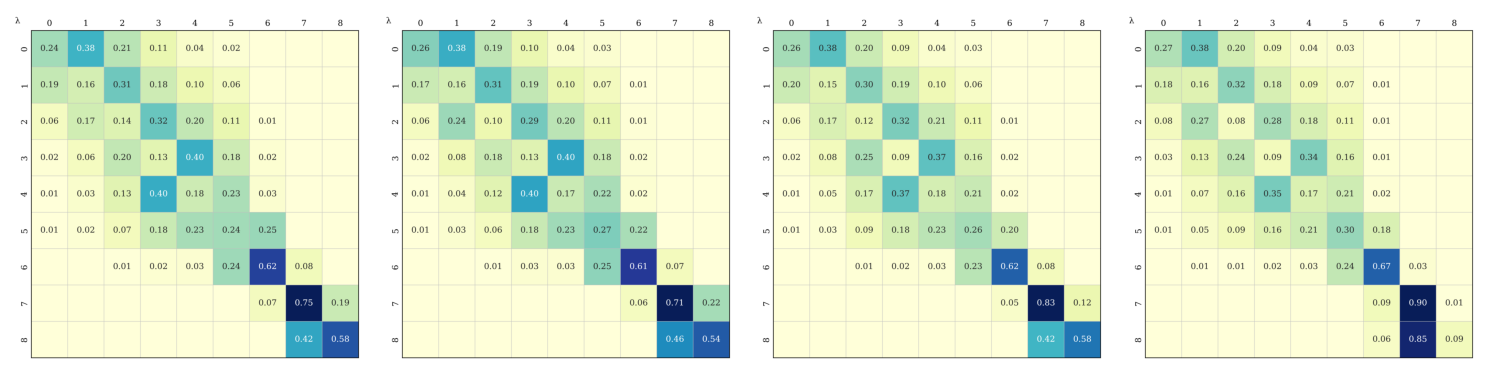

In [18]:
images = [f'example_outputs/analysis/traj_{i}_state_transmtx.png' for i in range(4)]
display_images_matplotlib(images, rows=1, figsize=(15, 7.5))

In addition to plotting continuous state-space trajectories, it could also be interesting to plot the time series of state visitation for different sets of states. That is, in the left figure below, each time series is contributed by different replicas at different times and the state vistation histogram for each state set is shown in the right figure. Note that ideally, the histograms on the right should be flat, but any $N_\text{ratio}$ (highest count/lowest count) below 5 is generally acceptable for a short simulation like this one.

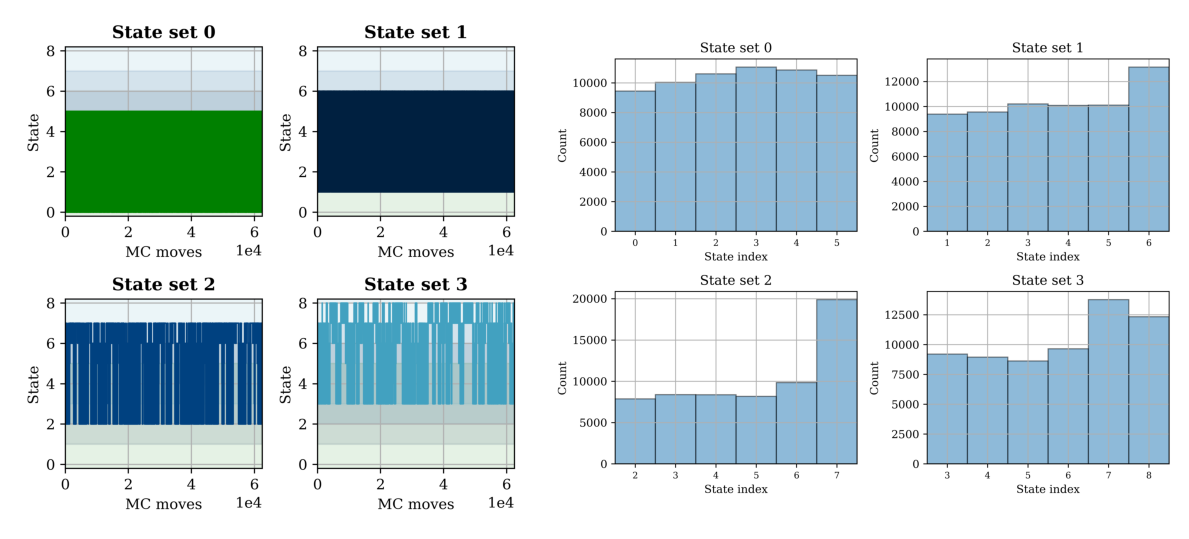

In [22]:
images = ['example_outputs/analysis/state_trajs_for_sim.png', 'example_outputs/analysis/state_hist_for_sim.png']
display_images_matplotlib(images, rows=1, figsize=(12, 6), widths=[45, 55])

As shown in `analyze_REXEE_log.txt`, we have also calculated the time it takes for a simulation replica to traverse the state space in either direction, as well as the round-trip time. These transit times are shown in the figure below.

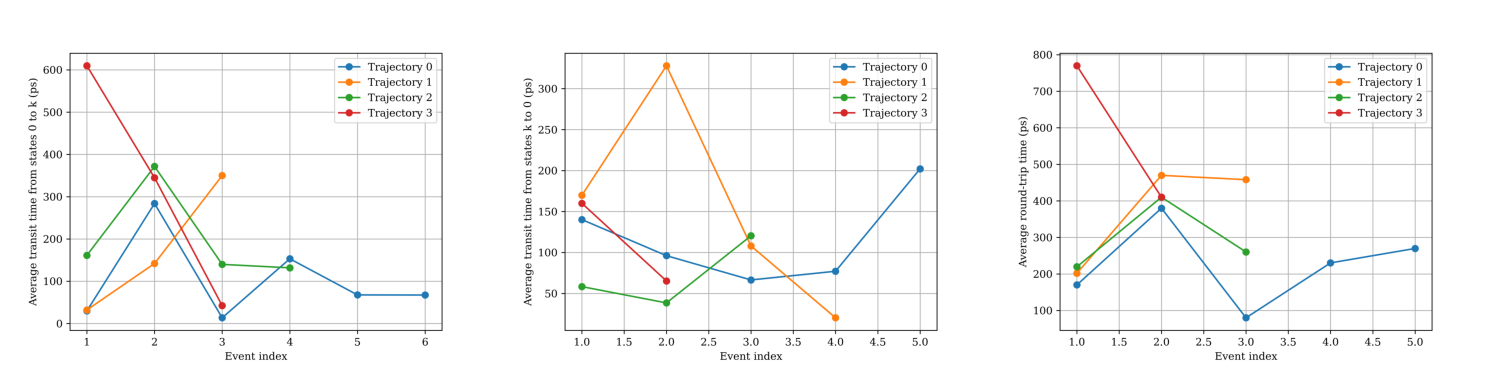

In [21]:
images = ['example_outputs/analysis/t_0k.png', 'example_outputs/analysis/t_k0.png', 'example_outputs/analysis/t_roundtrip.png']
display_images_matplotlib(images, rows=1, figsize=(15, 7.5))

### 4.3. Free energy calculation
As shown in `analyze_`

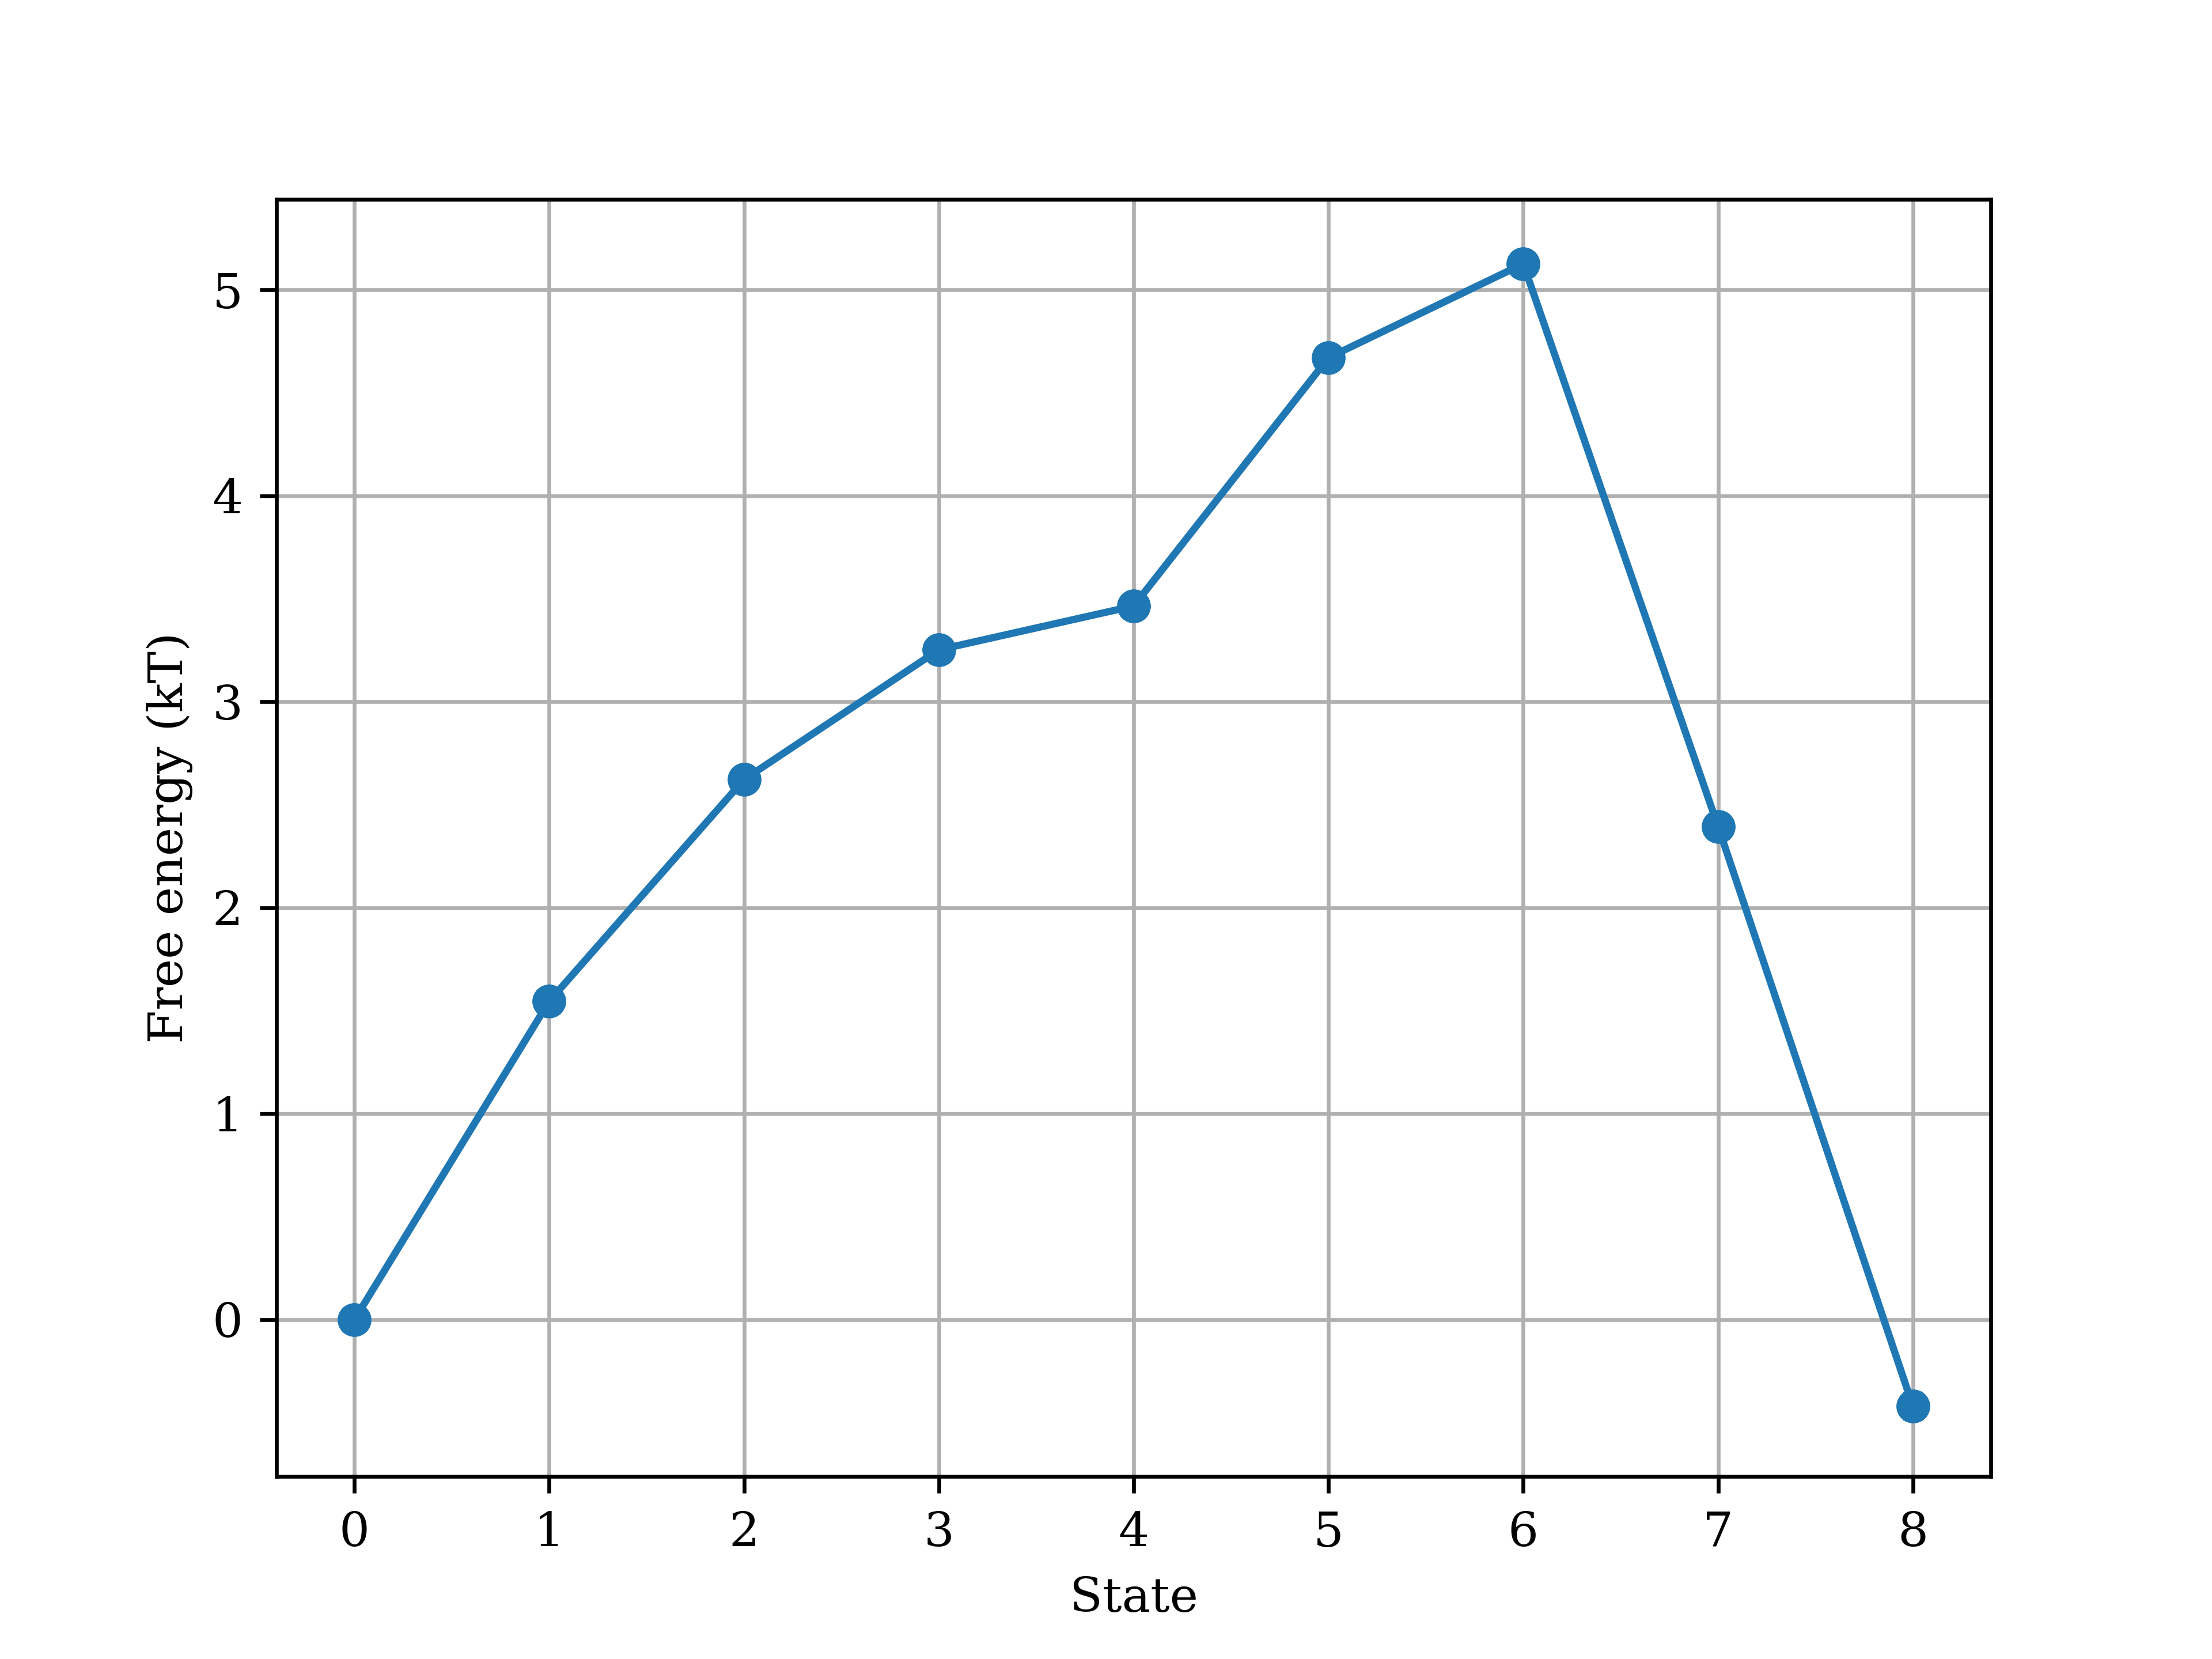

In [21]:
display(Image(filename='example_outputs/analysis/free_energy_profile.png', width=400))

---
If you have any questions or suggestions about this tutorial, please feel free to [file an issue on the GitHub repository](https://github.com/wehs7661/ensemble_md/issues) of the package `ensemble_md`. We are happy to help you out! If you find the package `ensemble_md` useful for your research, please cite the following paper: Hsu, W. T., & Shirts, M. R. (2024). Replica Exchange of Expanded Ensembles: A Generalized Ensemble Approach with Enhanced Flexibility and Parallelizability. *Journal of Chemical Theory and Computation*. doi: [10.1021/acs.jctc.4c00484](https://doi.org/10.1021/acs.jctc.4c00484)